In [1]:
import numpy as np
import cv2
import imghdr
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

C:\Users\Biswa\AppData\Local\Temp\ipykernel_8164\330859359.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [10]:
data_dir ='.\\datasets\\eczema_photos'

In [11]:
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/eczema_photos')

# Skin detection

In [12]:
validity_images_dict = {
    'invalidImage': list(data_dir.glob('invalid/*')),
    'ValidSkinImage': list(data_dir.glob('allSkin/*'))
}

In [13]:
validity_labels_dict = {
    'invalidImage': 0,
    'ValidSkinImage': 1
}

In [14]:
validity_labels = ['not a skin image', 'human skin image']

In [15]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [16]:
X, y = [], []
try:
    for validity, images in validity_images_dict.items():
        for image in images:
            tip = imghdr.what(str(image))
            if tip in image_exts:
                img = cv2.imread(str(image))
                resized_img = cv2.resize(img,(224,224))
                X.append(resized_img)
                y.append(validity_labels_dict[validity])
except Exception as e:
    print(str(e))

In [17]:
X = np.array(X)
y = np.array(y)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [19]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [20]:
num_classes = 2
skin_detection_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/140-224-feature-vector/versions/2",
                   trainable=False),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
skin_detection_model.build([1, 224, 224, 3])

In [21]:
skin_detection_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1792)              4363712   
                                                                 
 dense (Dense)               (None, 2)                 3586      
                                                                 
Total params: 4,367,298
Trainable params: 3,586
Non-trainable params: 4,363,712
_________________________________________________________________


In [22]:
skin_detection_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['acc'])
skin_detection_model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
112/112 [==============================] - 76s 632ms/step - loss: 0.1119 - acc: 0.9590
Epoch 2/5
112/112 [==============================] - 69s 618ms/step - loss: 0.0295 - acc: 0.9919
Epoch 3/5
112/112 [==============================] - 69s 617ms/step - loss: 0.0170 - acc: 0.9986
Epoch 4/5
112/112 [==============================] - 69s 613ms/step - loss: 0.0114 - acc: 0.9994
Epoch 5/5
112/112 [==============================] - 69s 615ms/step - loss: 0.0083 - acc: 0.9997


In [23]:
skin_detection_model.evaluate(X_test_scaled, y_test)

38/38 [==============================] - 24s 608ms/step - loss: 0.0149 - acc: 0.9949


[0.014932927675545216, 0.994945228099823]

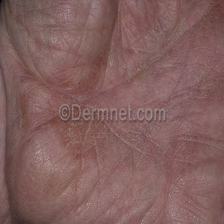

In [24]:
IMAGE_SHAPE = (224, 224)
test_image = Image.open('eczema-acute-4.jpg').resize(IMAGE_SHAPE)
test_image

In [25]:
test_image = np.array(test_image)/255.0
test_image_input = test_image[np.newaxis, ...]
result = skin_detection_model.predict(test_image_input)
validity_labels[np.argmax(result)]

1/1 [==============================] - 0s 400ms/step


'human skin image'

# Eczema detection

In [26]:
eczema_images_dict = {
    'clearSkin': list(data_dir.glob('clearSkin/*')),
    'eczema': list(data_dir.glob('eczema/*'))
}
eczema_labels_dict = {
    'clearSkin': 0,
    'eczema': 1
}
eczema_labels = ['clear skin', 'eczema']

In [27]:
X, y = [], []
try:
    for validity, images in eczema_images_dict.items():
        for image in images:
            tip = imghdr.what(str(image))
            if tip in image_exts:
                img = cv2.imread(str(image))
                resized_img = cv2.resize(img,(224,224))
                X.append(resized_img)
                y.append(eczema_labels_dict[validity])
except Exception as e:
    print(str(e))

In [28]:
X = np.array(X)
y = np.array(y)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [30]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [31]:
num_classes = 2
eczema_detection_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/140-224-feature-vector/versions/2",
                   trainable=False),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
eczema_detection_model.build([1, 224, 224, 3])
eczema_detection_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1792)              4363712   
                                                                 
 dense_1 (Dense)             (None, 2)                 3586      
                                                                 
Total params: 4,367,298
Trainable params: 3,586
Non-trainable params: 4,363,712
_________________________________________________________________


In [32]:
eczema_detection_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['acc'])
eczema_detection_model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
57/57 [==============================] - 41s 642ms/step - loss: 0.1636 - acc: 0.9349
Epoch 2/5
57/57 [==============================] - 39s 688ms/step - loss: 0.0376 - acc: 0.9922
Epoch 3/5
57/57 [==============================] - 38s 659ms/step - loss: 0.0235 - acc: 0.9961
Epoch 4/5
57/57 [==============================] - 37s 658ms/step - loss: 0.0160 - acc: 0.9983
Epoch 5/5
57/57 [==============================] - 37s 657ms/step - loss: 0.0116 - acc: 0.9994


In [33]:
eczema_detection_model.evaluate(X_test_scaled, y_test)

19/19 [==============================] - 13s 655ms/step - loss: 0.0145 - acc: 0.9933


[0.014474119059741497, 0.9933221936225891]

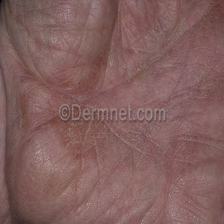

In [34]:
IMAGE_SHAPE = (224, 224)
test_image = Image.open('eczema-acute-4.jpg').resize(IMAGE_SHAPE)
test_image

In [35]:
test_image = np.array(test_image)/255.0
test_image_input = test_image[np.newaxis, ...]
result = eczema_detection_model.predict(test_image_input)
eczema_labels[np.argmax(result)]

1/1 [==============================] - 0s 401ms/step


'eczema'

# Eczema level detection

In [36]:
eczema_level_images_dict = {
    'mild': list(data_dir.glob('mild/*')),
    'moderate': list(data_dir.glob('moderate/*')),
    'severe': list(data_dir.glob('severe/*'))
}
eczema_level_labels_dict = {
    'mild': 0,
    'moderate': 1,
    'severe': 2
}

In [2]:
eczema_levels = ['mild', 'moderate','severe']

In [37]:
X, y = [], []
try:
    for level, images in eczema_level_images_dict.items():
        for image in images:
            tip = imghdr.what(str(image))
            if tip in image_exts:
                img = cv2.imread(str(image))
                resized_img = cv2.resize(img,(224,224))
                X.append(resized_img)
                y.append(eczema_level_labels_dict[level])
except Exception as e:
    print(str(e))

In [38]:
X = np.array(X)
y = np.array(y)

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [40]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [41]:
num_classes = 3
eczema_level_detection_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/140-224-feature-vector/versions/2",
                   trainable=False),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
eczema_level_detection_model.build([1, 224, 224, 3])
eczema_level_detection_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1792)              4363712   
                                                                 
 dense_2 (Dense)             (None, 3)                 5379      
                                                                 
Total params: 4,369,091
Trainable params: 5,379
Non-trainable params: 4,363,712
_________________________________________________________________


In [42]:
eczema_level_detection_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['acc'])
eczema_level_detection_model.fit(X_train_scaled, y_train, epochs=20)

Epoch 1/15
29/29 [==============================] - 23s 637ms/step - loss: 1.0654 - acc: 0.4728
Epoch 2/15
29/29 [==============================] - 19s 662ms/step - loss: 0.8392 - acc: 0.5969
Epoch 3/15
29/29 [==============================] - 19s 660ms/step - loss: 0.7452 - acc: 0.6645
Epoch 4/15
29/29 [==============================] - 19s 662ms/step - loss: 0.6786 - acc: 0.7157
Epoch 5/15
29/29 [==============================] - 19s 660ms/step - loss: 0.6371 - acc: 0.7451
Epoch 6/15
29/29 [==============================] - 19s 660ms/step - loss: 0.5882 - acc: 0.7789
Epoch 7/15
29/29 [==============================] - 19s 660ms/step - loss: 0.5400 - acc: 0.8126
Epoch 8/15
29/29 [==============================] - 19s 660ms/step - loss: 0.5137 - acc: 0.8159
Epoch 9/15
29/29 [==============================] - 19s 661ms/step - loss: 0.4804 - acc: 0.8399
Epoch 10/15
29/29 [==============================] - 19s 662ms/step - loss: 0.4605 - acc: 0.8475
Epoch 11/15
29/29 [====================

In [43]:
eczema_level_detection_model.evaluate(X_test_scaled, y_test)

10/10 [==============================] - 6s 576ms/step - loss: 0.8092 - acc: 0.6144


[0.8091636896133423, 0.6143791079521179]

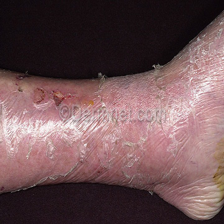

In [44]:
IMAGE_SHAPE = (224, 224)
test_image = Image.open('desquamation-4.jpg').resize(IMAGE_SHAPE)
test_image

In [45]:
test_image = np.array(test_image)/255.0
test_image_input = test_image[np.newaxis, ...]
result = eczema_level_detection_model.predict(test_image_input)
eczema_levels[np.argmax(result)]

1/1 [==============================] - 0s 436ms/step


'severe'

# classifying a complete image

In [46]:
def classifyImage(path):
    IMAGE_SHAPE = (224, 224)
    test_image = Image.open(str(pathlib.Path(path))).resize(IMAGE_SHAPE)
    test_image = np.array(test_image)/255.0
    test_image_input = test_image[np.newaxis, ...]
    result1 = np.argmax(skin_detection_model.predict(test_image_input))
    if result1 == 0:
        print("Invalid Image")
    else:
        result2 = np.argmax(eczema_detection_model.predict(test_image_input))
        if result2 == 0:
            print("No eczema")
        else:
            result3 = np.argmax(eczema_level_detection_model(test_image_input))
            print(eczema_levels[result3])
        

In [47]:
classifyImage('desquamation-4.jpg')

1/1 [==============================] - 0s 24ms/step
severe


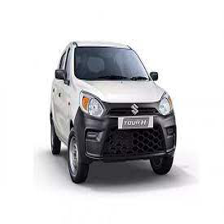

In [48]:
IMAGE_SHAPE = (224, 224)
test_image = Image.open('alto.jpg').resize(IMAGE_SHAPE)
test_image

In [49]:
classifyImage('alto.jpg')

1/1 [==============================] - 0s 44ms/step
Invalid Image


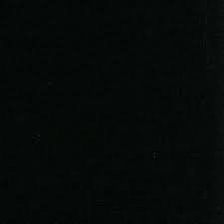

In [50]:
IMAGE_SHAPE = (224, 224)
test_image = Image.open('black.jpg').resize(IMAGE_SHAPE)
test_image

In [51]:
classifyImage('black.jpg')

1/1 [==============================] - 0s 27ms/step
Invalid Image


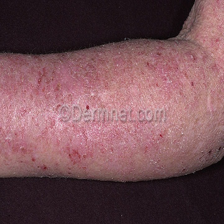

In [52]:
IMAGE_SHAPE = (224, 224)
test_image = Image.open('03DermatitisArm1.jpg').resize(IMAGE_SHAPE)
test_image

In [53]:
classifyImage('03DermatitisArm1.jpg')

1/1 [==============================] - 0s 32ms/step
moderate


# save model

In [55]:
from tensorflow.keras.models import load_model

In [56]:
skin_detection_model.save('skinDetection.h5')
eczema_detection_model.save('eczemaDetection.h5')
eczema_level_detection_model.save('eczemaLevelDetection.h5')

# load from model file

In [3]:
skin_detection_loaded_model = tf.keras.models.load_model(("skinDetection.h5"), custom_objects={'KerasLayer':hub.KerasLayer})
eczema_detection_loaded_model = tf.keras.models.load_model(("eczemaDetection.h5"), custom_objects={'KerasLayer':hub.KerasLayer})
eczema_level_detection_loaded_model = tf.keras.models.load_model(("eczemaLevelDetection.h5"), custom_objects={'KerasLayer':hub.KerasLayer})

In [4]:
def classifyImageFromLoadedModel(path):
    IMAGE_SHAPE = (224, 224)
    test_image = Image.open(str(pathlib.Path(path))).resize(IMAGE_SHAPE)
    test_image = np.array(test_image)/255.0
    test_image_input = test_image[np.newaxis, ...]
    result1 = np.argmax(skin_detection_loaded_model.predict(test_image_input))
    if result1 == 0:
        print("Invalid Image")
    else:
        result2 = np.argmax(eczema_detection_loaded_model.predict(test_image_input))
        if result2 == 0:
            print("No eczema")
        else:
            result3 = np.argmax(eczema_level_detection_loaded_model(test_image_input))
            print(eczema_levels[result3])

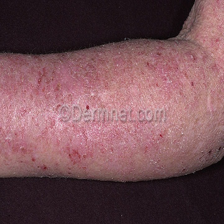

In [5]:
IMAGE_SHAPE = (224, 224)
test_image = Image.open('03DermatitisArm1.jpg').resize(IMAGE_SHAPE)
test_image

In [6]:
classifyImageFromLoadedModel('03DermatitisArm1.jpg')

1/1 [==============================] - 0s 438ms/step
moderate
